<a href="https://colab.research.google.com/github/oliver6899/AQM/blob/main/Lecture_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Lecture 7: A Practical Guide to Multiple Linear Regression"
---

This notebook walks through the complete process of building, diagnosing, and refining a multiple linear regression model, following the narrative of Lecture 7. We will use a dataset on wages to understand the key drivers of hourly pay.

In [ ]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels is the go-to library for statistical inference and regression in Python
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# PATSY IMPORT FOR FORMULA HANDLING - THIS IS THE FIX
from patsy import dmatrices

# Set plot style for the notebook
sns.set_theme(style="whitegrid")

## Step 1: The Problem - Is Simple Linear Regression Enough?

We begin, as in the lecture, by asking a simple question: can education alone explain wages? We fit a Simple Linear Regression (SLR) model to see its limitations.

--- Simple Linear Regression Results ---
                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     103.4
Date:                Tue, 21 Oct 2025   Prob (F-statistic):           2.78e-22
Time:                        07:30:25   Log-Likelihood:                -1385.7
No. Observations:                 526   AIC:                             2775.
Df Residuals:                     524   BIC:                             2784.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  

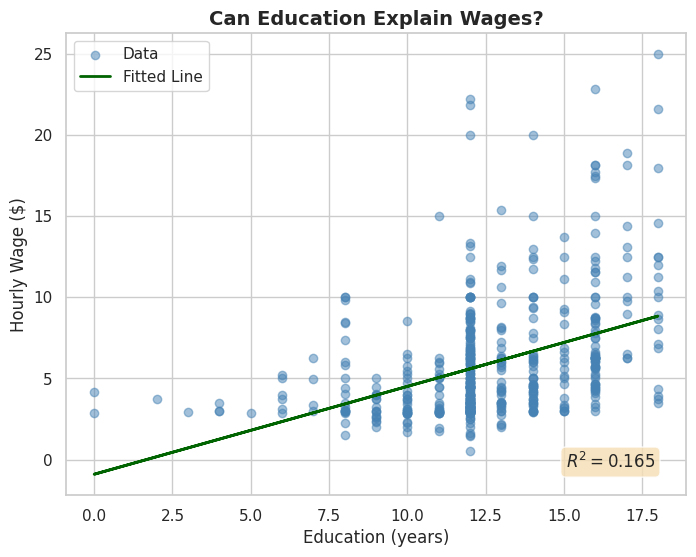

In [ ]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/aaubs/AQM-2025/refs/heads/main/mult_reg_data.csv')

# --- 1a: Fit the Simple Linear Regression Model ---
# We use statsmodels' formula API, which is clear and powerful.
# The formula "wage ~ educ" means "predict wage using education".
slr_model = smf.ols("wage ~ educ", data=df).fit()

# Print the model summary to see the coefficients and R-squared
print("--- Simple Linear Regression Results ---")
print(slr_model.summary())

# --- 1b: Visualize the SLR Model ---
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df['educ'], df['wage'], alpha=0.5, color='steelblue', label='Data')
ax.plot(df['educ'], slr_model.fittedvalues, color='darkgreen', linewidth=2, label='Fitted Line')

ax.set_title('Can Education Explain Wages?', fontsize=14, fontweight='bold')
ax.set_xlabel('Education (years)', fontsize=12)
ax.set_ylabel('Hourly Wage ($)', fontsize=12)
ax.legend(loc='upper left')

# Add R-squared annotation
ax.text(0.95, 0.05, f'$R^2 = {slr_model.rsquared:.3f}$',
        transform=ax.transAxes, fontsize=12, ha='right', va='bottom',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.show()

In [ ]:
df.to_csv('mult_reg_data.csv')

The model is statistically significant, but the low R-squared (0.165) tells us we're missing a lot of the story. Let's examine the residuals.

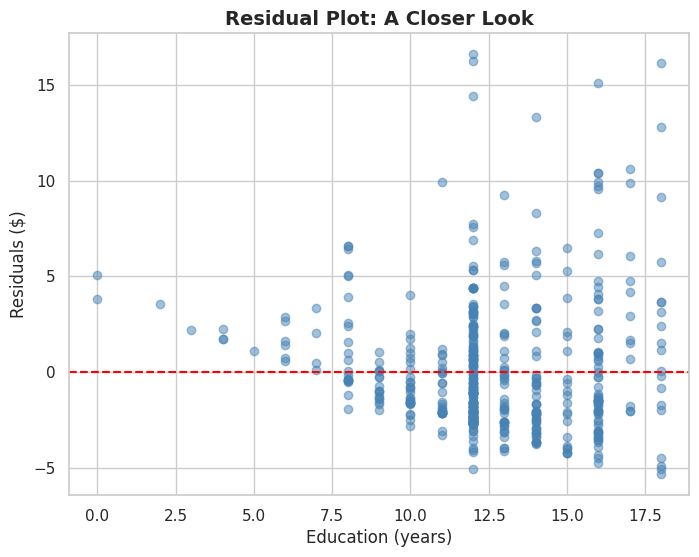

In [ ]:
# --- 1c: Plot the Residuals of the SLR Model ---
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df['educ'], slr_model.resid, alpha=0.5, color='steelblue')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

ax.set_title('Residual Plot: A Closer Look', fontsize=14, fontweight='bold')
ax.set_xlabel('Education (years)', fontsize=12)
ax.set_ylabel('Residuals ($)')
plt.show()



## Step 2: Building the "First Pass" Multiple Regression Model

We will now build a more complex model that includes experience and tenure, along with their squared terms to capture potential non-linear effects. First, we must prepare our data.

### 2a: Addressing Multicollinearity with Centering

As discussed in the lecture, including a variable and its square (like `exper` and `expersq`) creates structural multicollinearity. We diagnose this with the Variance Inflation Factor (VIF) and fix it by centering the variables.

In [ ]:
# Create squared terms for the initial check
df['expersq'] = df['exper']**2
df['tenursq'] = df['tenure']**2

# --- VIF Check BEFORE Centering ---
# Define the predictors for the model
predictors_before = 'educ + exper + expersq + tenure + tenursq'
# Use patsy to create the design matrix from the formula
y, X_before = dmatrices(f"wage ~ {predictors_before}", data=df, return_type='dataframe')

vif_before = pd.DataFrame()
vif_before["Variable"] = X_before.columns
# CORRECTED LINE: Use .shape[1] to get the number of columns
vif_before["VIF"] = [variance_inflation_factor(X_before.values, i) for i in range(X_before.shape[1])]
vif_before = vif_before[vif_before["Variable"] != "Intercept"]
print("--- VIF Before Centering ---")
print(vif_before)

# --- The Solution: Centering ---
df['exper_c'] = df['exper'] - df['exper'].mean()
df['tenure_c'] = df['tenure'] - df['tenure'].mean()
df['expersq_c'] = df['exper_c']**2
df['tenursq_c'] = df['tenure_c']**2

# --- VIF Check AFTER Centering ---
predictors_after = 'educ + exper_c + expersq_c + tenure_c + tenursq_c'
y, X_after = dmatrices(f"wage ~ {predictors_after}", data=df, return_type='dataframe')

vif_after = pd.DataFrame()
vif_after["Variable"] = X_after.columns
# CORRECTED LINE: Use .shape[1] here as well
vif_after["VIF"] = [variance_inflation_factor(X_after.values, i) for i in range(X_after.shape[1])]
vif_after = vif_after[vif_after["Variable"] != "Intercept"]
print("\n--- VIF After Centering ---")
print(vif_after)

--- VIF Before Centering ---
  Variable        VIF
1     educ   1.143123
2    exper  14.976644
3  expersq  14.350605
4   tenure   7.960045
5  tenursq   7.195029

--- VIF After Centering ---
    Variable       VIF
1       educ  1.143123
2    exper_c  2.192655
3  expersq_c  1.738187
4   tenure_c  3.845452
5  tenursq_c  3.274732


**Observation:** Just as we saw in the lecture, the residuals "fan out." This pattern is **heteroscedasticity**, a violation of a key regression assumption. It confirms that our simple model is inadequate and that other variables are needed.

---

**Result:** The VIFs are now all well below 5, indicating that we have successfully solved the multicollinearity problem. We can now proceed with fitting our model.

### 2b: Fitting the MLR Model

Now we fit the multiple linear regression model using our corrected (centered) variables.

In [ ]:
# Define and fit the model
mlr_formula = "wage ~ educ + exper_c + expersq_c + tenure_c + tenursq_c"
mlr_model = smf.ols(mlr_formula, data=df).fit()

# Print the full summary table
print("--- 'First Pass' Multiple Regression Results ---")
print(mlr_model.summary())

--- 'First Pass' Multiple Regression Results ---
                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     55.22
Date:                Thu, 16 Oct 2025   Prob (F-statistic):           5.34e-46
Time:                        09:39:10   Log-Likelihood:                -1321.1
No. Observations:                 526   AIC:                             2654.
Df Residuals:                     520   BIC:                             2680.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Int

**Interpretation:** This is our "first pass" model. The R-squared has jumped to 0.347, a huge improvement! The F-test shows the model is significant, and most predictors have significant p-values. On the surface, this looks good. But is it reliable?

---

## Step 3: Diagnosing the MLR Model's Flaws

As the lecture stresses, we cannot trust the output table until we check the residuals for other assumption violations.

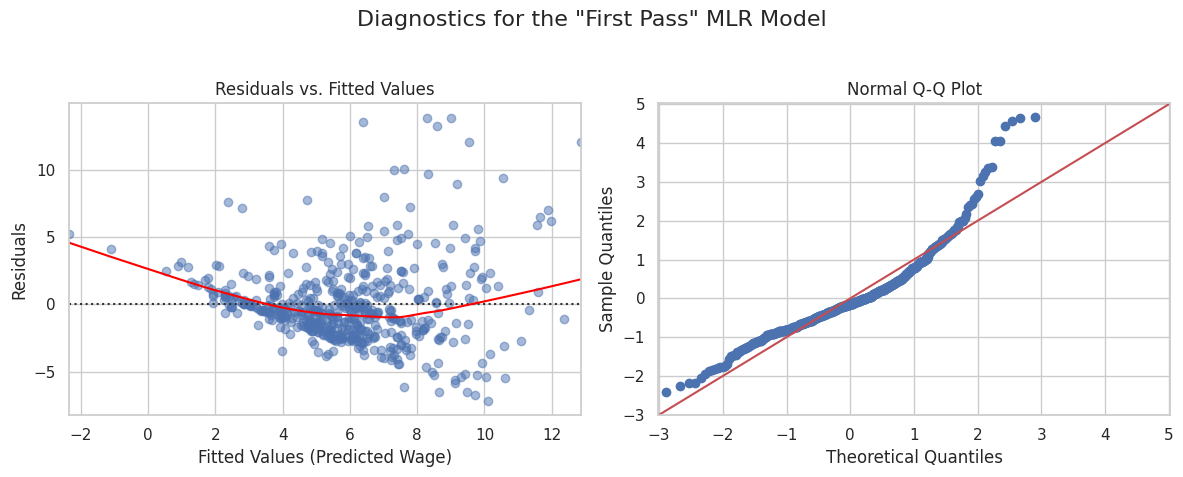

In [ ]:
# --- Create Diagnostic Plots for the MLR Model ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Diagnostics for the "First Pass" MLR Model', fontsize=16)

# Plot 1: Residuals vs. Fitted
sns.residplot(x=mlr_model.fittedvalues, y=mlr_model.resid, lowess=True,
              scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1.5}, ax=ax1)
ax1.set_title('Residuals vs. Fitted Values')
ax1.set_xlabel('Fitted Values (Predicted Wage)')
ax1.set_ylabel('Residuals')

# Plot 2: Normal Q-Q Plot
sm.qqplot(mlr_model.resid, line='45', fit=True, ax=ax2)
ax2.set_title('Normal Q-Q Plot')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Diagnosis:** These plots confirm the serious problems we identified in the lecture. The curved, fanning pattern in the residual plot and the skewed Q-Q plot tell us that this model, despite its good R-squared, is fundamentally flawed and its results are unreliable.

---

## Step 4: The Solution - The Log-Linear Model

The diagnostic plots pointed to a classic solution for wage data: transforming the dependent variable by taking its natural logarithm.

In [ ]:
# --- 4a: Create the log_wage variable and fit the new model ---
df['log_wage'] = np.log(df['wage'])

log_formula = "log_wage ~ educ + exper_c + expersq_c + tenure_c + tenursq_c"
log_model = smf.ols(log_formula, data=df).fit()

# Print the final model's summary
print("--- Final Log-Linear Model Results ---")
print(log_model.summary())

--- Final Log-Linear Model Results ---
                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     60.26
Date:                Thu, 16 Oct 2025   Prob (F-statistic):           1.74e-49
Time:                        09:39:45   Log-Likelihood:                -293.23
No. Observations:                 526   AIC:                             598.5
Df Residuals:                     520   BIC:                             624.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    

**Interpretation:** This is our final, most reliable model. Note the improved Adjusted R-squared (0.361) and that all predictors, including `tenursq_c`, are now highly significant. The coefficients must now be interpreted as percentage changes.

---

## Step 5: Final Validation - Did Our Fix Work?

The final step is to check the diagnostic plots for our new log-linear model to confirm that the transformation solved the problems.

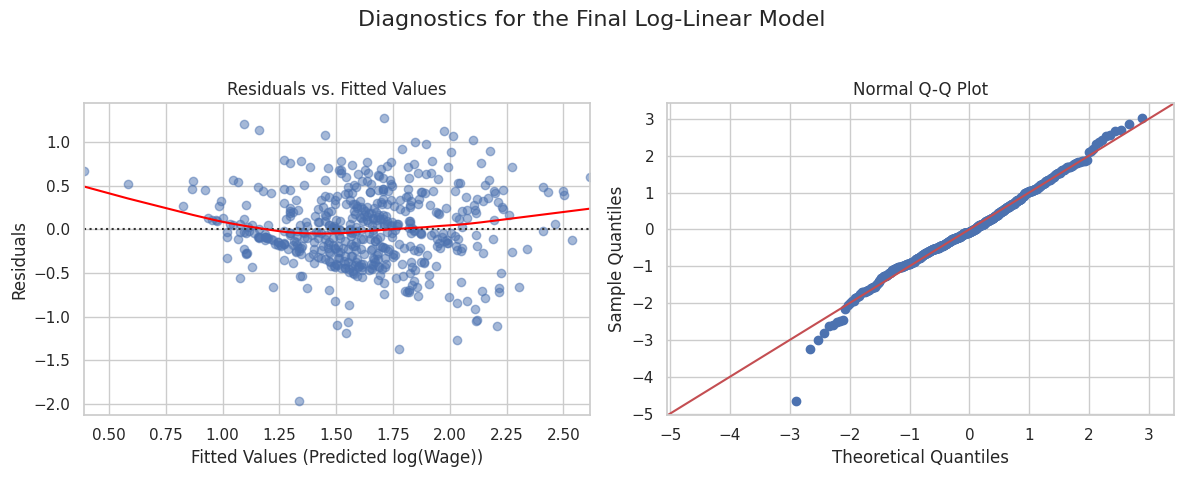

In [ ]:
# --- Create Diagnostic Plots for the FINAL Log-Linear Model ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Diagnostics for the Final Log-Linear Model', fontsize=16)

# Plot 1: Residuals vs. Fitted
sns.residplot(x=log_model.fittedvalues, y=log_model.resid, lowess=True,
              scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1.5}, ax=ax1)
ax1.set_title('Residuals vs. Fitted Values')
ax1.set_xlabel('Fitted Values (Predicted log(Wage))')
ax1.set_ylabel('Residuals')

# Plot 2: Normal Q-Q Plot
sm.qqplot(log_model.resid, line='45', fit=True, ax=ax2)
ax2.set_title('Normal Q-Q Plot')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Conclusion:** Success! The "after" plots show a massive improvement. The residual plot is now much more of a random "cloud" without fanning, and the Q-Q plot hugs the diagonal line closely. This confirms that our final log-linear model is robust, reliable, and its results can be trusted. This completes our analytical journey.